## pip install

In [6]:
%pip install nb-black
%pip install plotly
%pip install torchtext
%load_ext autoreload
%autoreload 2
%load_ext lab_black
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import torch
import sys
import pickle
import torchtext
from sklearn.manifold import TSNE
import plotly.graph_objects as go

sys.path.append("../")

## Loading Model and Vocabulary

In [8]:
folder = "weights/skipgram_WikiText2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ds_name = 'WikiText2'

RANGE = str(36718)
epochs = str(3)
min_count = str(50)
batch_size = str(128)
embed_dim = str(2)
lr = str(0.001)
window = str(10)
neg_count = str(5)

model_path = ("/epochs_" + epochs + "_min_count_" + min_count + "_batch_size_"  + batch_size 
+ "_embed_dim_" +  embed_dim + "_lr_" + lr + "_window_" + window + "_neg_count_" + neg_count)

folder_final = folder + model_path
infos_path = 'infos_' + ds_name + '_' + RANGE + '_min_count_' + min_count + '.pickle'

model = torch.load(f'../{folder_final}/model.pt', map_location=device)

vocab_notInOrder = torch.load(f"../{folder_final}/vocab.pt")

####non ho le frequenze le devo importare#####
with open('/home/fmollica/Downloads/' + infos_path, 'rb') as handle:
    infos = pickle.load(handle)
    word_frequency_vocab = infos["word_frequency_vocab"]
    word2id = infos["word2id"]
    id2word = infos["id2word"]

word_frequency_vocab = {k: v for k, v in sorted(word_frequency_vocab.items(), key=lambda item: item[1], reverse=True)}


vocab = torchtext.vocab.vocab(word_frequency_vocab)

In [7]:
len(word_frequency_vocab)

3940

In [3]:
model.eval()

BoxModel(
  (embeddings_word): BoxEmbedding(3940, 4)
  (embeddings_context): BoxEmbedding(3940, 4)
  (box_vol): Volume()
  (box_int): Intersection()
)

In [4]:
boxes = model.embeddings_word.all_boxes

In [5]:
model.most_similar("father", 5)

AttributeError: 'BoxModel' object has no attribute 'model'

In [187]:
import matplotlib.patches as patches
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib._color_data as mcd
import random

colors = [name for name in mcd.CSS4_COLORS
           if "xkcd:" + name in mcd.XKCD_COLORS]


def extract_embeddings(boxes):
        list_box = []
        list_box.append(boxes.z.data.tolist())
        list_box.append(boxes.Z.data.tolist())
        rect = patches.Rectangle((list_box[0][0], list_box[0][1]), 
                    list_box[1][0] - list_box[0][0], 
                    list_box[1][1] - list_box[0][1])
        
        rx, ry = rect.get_xy()
        cx = rx + rect.get_width()/2.0
        cy = ry + rect.get_height()/2.0

        return rect, [list_box[0][0], list_box[0][1], list_box[1][0], list_box[1][1]], cx, cy

lis_all = list(range(len(vocab_notInOrder)))
center_x = []
center_y = []
words = []
all_rect = []
points = []

for i in lis_all:
    emb = boxes[i]
    rect, p, cx, cy = extract_embeddings(emb)
    all_rect.append(rect)
    points.append(p)
    center_x.append(cx)
    center_y.append(cy)
    words.append(vocab_notInOrder.lookup_tokens([i])[0])

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=center_x,
        y=center_y,
        mode="text",
        text=words,
        textposition="middle center",
        textfont=dict(color="black"),
    )
)

fig.update_xaxes(range=[0, 1])
fig.update_yaxes(range=[0, 1])

#for i, point in enumerate(points):
#  color = "#%06x" % random.randint(0, 0xFFFFFF)
#  fig.add_shape(type="rect",
#      x0=point[0], y0=point[1], x1=point[2], y1=point[3],
#      line=dict(color=color),
#  )

fig.update_layout(margin=dict(l=80, r=80, t=80, b=80), title={
            'text' : "epochs_" + epochs + "_min_count_" + min_count + "_batch_size_"  + batch_size 
            + "_embed_dim_" +  embed_dim + "_lr_" + lr + "_window_" + window + "_neg_count_" + neg_count,
            'x':0.5,
            'xanchor': 'center'
        } )

fig.write_html(f'../{folder_final}/word2box_target_visualization.html')
fig.show()


## N Volumi più grandi e piccoli dello spazio target e context

In [38]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ipywidgets import interact
from copy import copy
import matplotlib._color_data as mcd


def print_volumes(volumes, N, title):
    idx = (-volumes).argsort()
    words_ = []
    words_frequency_ = []
    volumes_ = []
    for i, index in enumerate(idx.tolist()[0:N]):
        words_.append(vocab.lookup_token(index))
        words_frequency_.append(word_frequency_vocab[vocab.lookup_token(index)])
        volumes_.append(volumes[index].item())

    fig, ax = plt.subplots(figsize=(30, 5))
    plt.xticks(rotation=90)
    ax.set_title(title)
    ax.plot(words_, volumes_)


N = 50

###### TARGET VOLUME GRANDI ########
volumes_target = model.box_vol(model.embeddings_word.all_boxes)
print_volumes(volumes_target, N, "Volumi target grandi")
###### TARGET VOLUME PICCOLI ########
volumes_target = model.box_vol(model.embeddings_word.all_boxes)
print_volumes(-volumes_target, N, "Volumi target piccoli")
###### CONTEXT VOLUMI GRANDI #########
volumes_context = model.box_vol(model.embeddings_context.all_boxes)
print_volumes(volumes_context, N, "Volumi context grandi")
###### CONTEXT VOLUMI PICCOLI #########
volumes_context = model.box_vol(model.embeddings_context.all_boxes)
print_volumes(-volumes_context, N, "Volumi context piccoli")

RuntimeError: Specified index 2311 is out of bounds for vocab of size 2249

## Volumi N parole più frequenti e meno frequenti dello spazio target e context

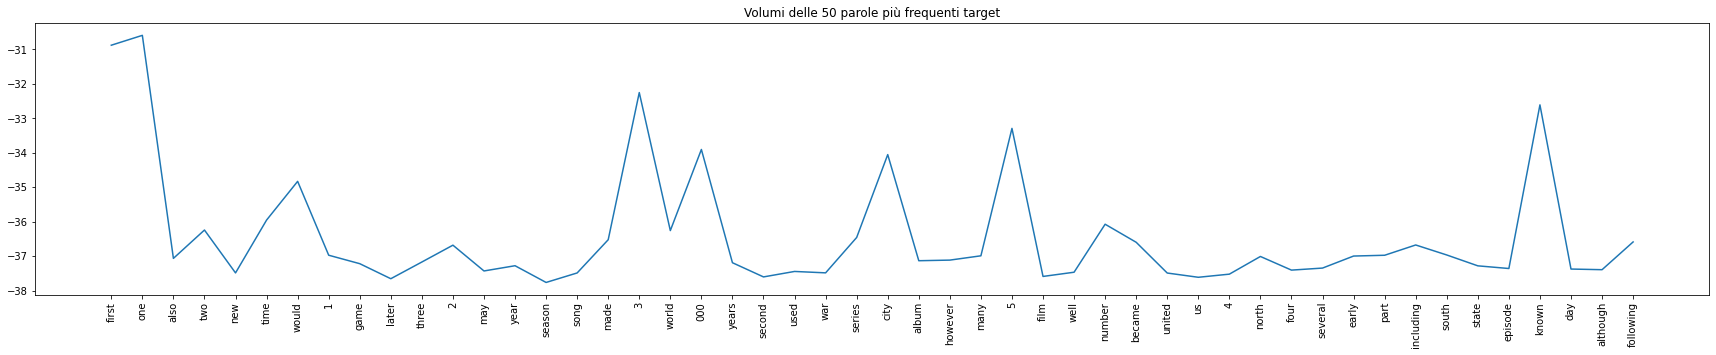

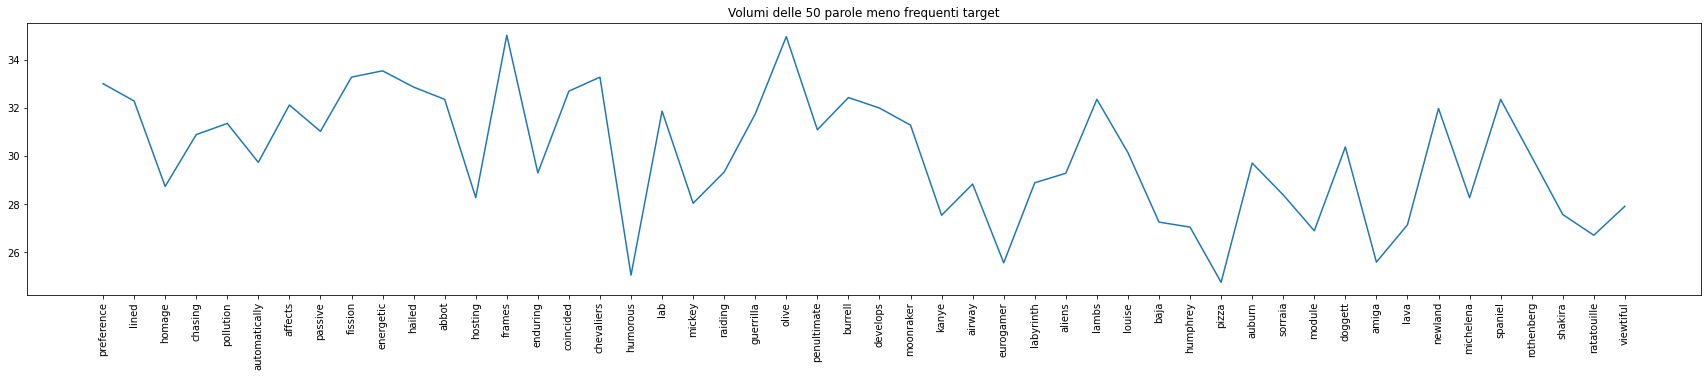

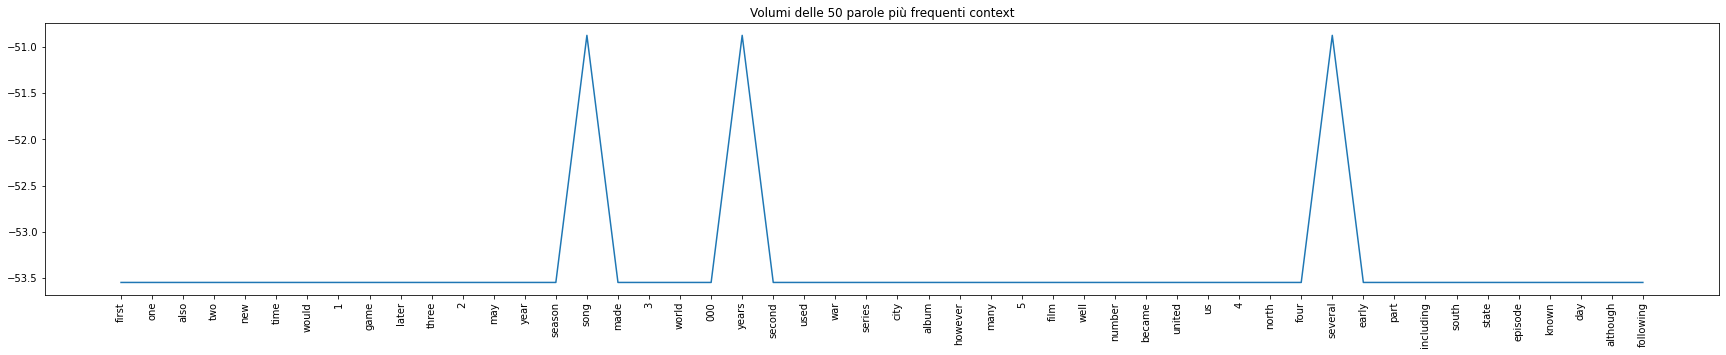

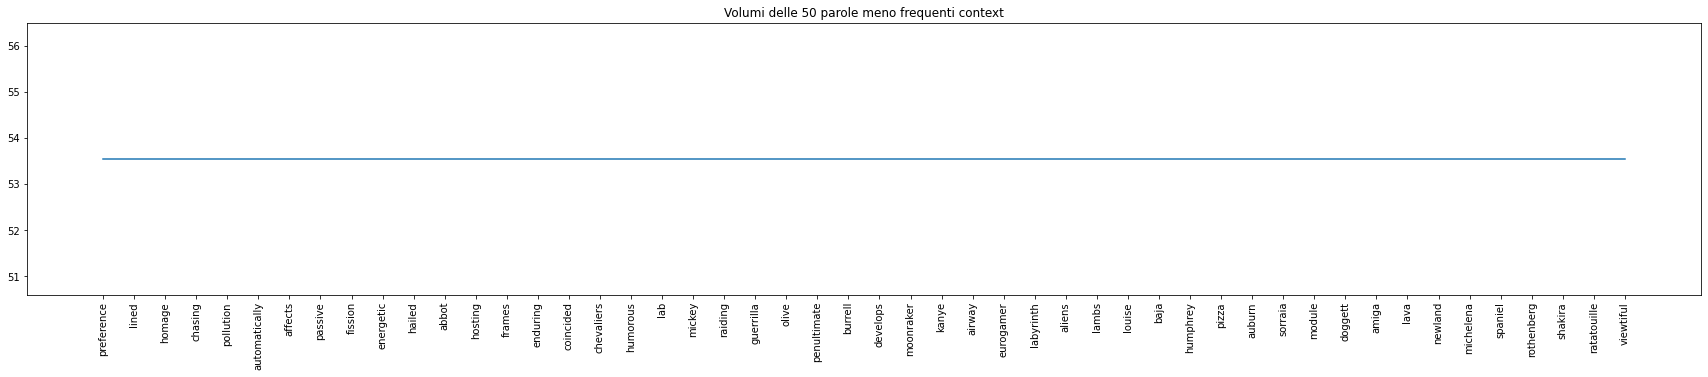

In [24]:
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ipywidgets import interact, interactive
from copy import copy
import matplotlib._color_data as mcd
import matplotlib.patches as mpatch


###prendere parole più frequenti####


def print_volumes(volumes, list_words, title):
    words_ = []
    words_frequency_ = []
    volumes_ = []
    for i, word in enumerate(list_words):
        words_.append(word)
        words_frequency_.append(word_frequency_vocab[word])
        volumes_.append(volumes[vocab.lookup_indices([word])[0]].item())

    fig, ax = plt.subplots(figsize=(30, 5))
    plt.xticks(rotation=90)
    ax.set_title(title)
    ax.plot(words_, volumes_)


N = 50

#####le frequenze nel vocab sono già in ordine#####
list_higher_frequency_words = []

for i, tuple in enumerate(list(word_frequency_vocab.items())[0:N]):
    list_higher_frequency_words.append(tuple[0])

list_lowest_frequency_words = []

for i, tuple in enumerate(list(word_frequency_vocab.items())[-N:]):
    list_lowest_frequency_words.append(tuple[0])

###### TARGET VOLUMI N PAROLE FREQUENTI ########
volumes_target = box_vol(model.embeddings_word.all_boxes)
print_volumes(volumes_target, list_higher_frequency_words, "Volumi delle " + str(N) + " parole più frequenti target")
###### TARGET VOLUMI N PAROLE MENO FREQUENTI ########
volumes_target = box_vol(model.embeddings_word.all_boxes)
print_volumes(-volumes_target, list_lowest_frequency_words, "Volumi delle " + str(N) + " parole meno frequenti target")
###### CONTEXT VOLUMI N PAROLE FREQUENTI #########
volumes_context = box_vol(model.embeddings_context.all_boxes)
print_volumes(volumes_context, list_higher_frequency_words, "Volumi delle " + str(N) + " parole più frequenti context")
###### CONTEXT VOLUMI N PAROLE MENO FREQUENTI #########
volumes_context = box_vol(model.embeddings_context.all_boxes)
print_volumes(-volumes_context, list_lowest_frequency_words, "Volumi delle " + str(N) + " parole meno frequenti context")

## calcolo quantili

In [41]:
quantile = np.arange(0.0, 1.0, 0.1)
for i in quantile:
    print(np.quantile(list(word_frequency_vocab.values()),i))

50.0
58.0
68.0
81.0
100.0
124.0
159.0
213.0
316.0
571.0


## wordcloud dataset

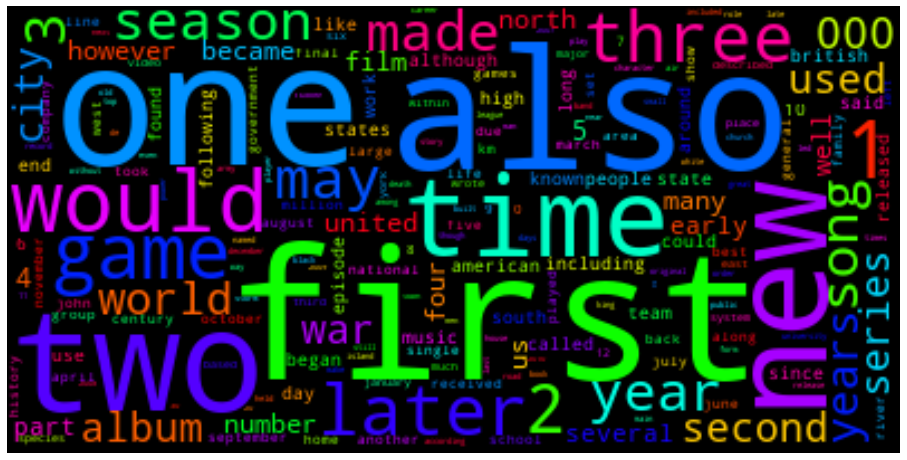

In [39]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

cloud = WordCloud(max_font_size=80, colormap="hsv").generate_from_frequencies(word_frequency_vocab)
plt.figure(figsize=(16, 12))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Getting Embeddings

In [1]:
# embedding from first model layer
embeddings = list(model.parameters())[0]
embeddings = embeddings.cpu().detach().numpy()

# normalization
norms = (embeddings ** 2).sum(axis=1) ** (1 / 2)
norms = np.reshape(norms, (len(norms), 1))
embeddings_norm = embeddings / norms
embeddings_norm.shape

NameError: name 'model' is not defined

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ipywidgets import interact, interactive
from copy import copy
import matplotlib._color_data as mcd
import matplotlib._color_data as mcd
import matplotlib.patches as mpatch
colors = [name for name in mcd.CSS4_COLORS
           if "xkcd:" + name in mcd.XKCD_COLORS]

list_entire = []
for i,elem in enumerate(myboxes):
  list_epoch = []
  for i, box in enumerate(elem):
    #print(box)
    rect = patches.Rectangle((box[0][0], box[0][1]), 
                            box[1][0] - box[0][0], 
                            box[1][1] - box[0][1], 
                            facecolor=colors[i], edgecolor = colors[i], lw=3, label=w2v.data.id2word[i], alpha=0.1)
    list_epoch.append(rect)
  list_entire.append(list_epoch)

def f2(epoch = (0, int(w2v.batch_count)-1, 1)):

    fig, ax = plt.subplots(figsize=(30, 10))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    #plt.plot([0.5, 0.5], [0, 4], 'k-', lw=2)
    for i,rectangle in enumerate(list_entire[epoch]):
      new_c=copy(rectangle)
      rx, ry = new_c.get_xy()
      cx = rx + new_c.get_width()/2.0
      cy = ry + new_c.get_height()/2.0
      ax.annotate(w2v.data.id2word[i], (cx, cy), color='black', fontsize=10, ha='center', va='center')
      ax.add_patch(new_c)
    #ax.legend()

interact(f2);

# Visualization with t-SNE

In [22]:
# get embeddings
embeddings_df = pd.DataFrame(embeddings)

# t-SNE transform
tsne = TSNE(n_components=2)
embeddings_df_trans = tsne.fit_transform(embeddings_df)
embeddings_df_trans = pd.DataFrame(embeddings_df_trans)

# get token order
embeddings_df_trans.index = vocab.itos

# if token is a number
is_numeric = embeddings_df_trans.index.str.isnumeric()

/home/fmollica/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/fmollica/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [24]:
color = np.where(is_numeric, "green", "black")
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=embeddings_df_trans[0],
        y=embeddings_df_trans[1],
        mode="text",
        text=embeddings_df_trans.index,
        textposition="middle center",
        textfont=dict(color=color),
    )
)
fig.write_html("../word2vec_visualization.html")

# Find Similar Words

In [7]:
def get_top_similar(word: str, topN: int = 10):
    word_id = vocab[word]
    if word_id == 0:
        print("Out of vocabulary word")
        return

    word_vec = embeddings_norm[word_id]
    word_vec = np.reshape(word_vec, (len(word_vec), 1))
    dists = np.matmul(embeddings_norm, word_vec).flatten()
    topN_ids = np.argsort(-dists)[1 : topN + 1]

    topN_dict = {}
    for sim_word_id in topN_ids:
        sim_word = vocab.lookup_token(sim_word_id)
        topN_dict[sim_word] = dists[sim_word_id]
    return topN_dict

In [9]:
for word, sim in get_top_similar("germany").items():
    print("{}: {:.3f}".format(word, sim))

italy: 0.677
netherlands: 0.569
france: 0.551
1917: 0.515
ireland: 0.489
poland: 0.469
britain: 0.467
1918: 0.462
spain: 0.460
november: 0.445


# Vector Equations

In [10]:
emb1 = embeddings[vocab["king"]]
emb2 = embeddings[vocab["man"]]
emb3 = embeddings[vocab["woman"]]

emb4 = emb1 - emb2 + emb3
emb4_norm = (emb4 ** 2).sum() ** (1 / 2)
emb4 = emb4 / emb4_norm

emb4 = np.reshape(emb4, (len(emb4), 1))
dists = np.matmul(embeddings_norm, emb4).flatten()

top5 = np.argsort(-dists)[:5]

for word_id in top5:
    print("{}: {:.3f}".format(vocab.lookup_token(word_id), dists[word_id]))

king: 0.707
son: 0.442
reign: 0.434
lord: 0.420
woman: 0.409
